In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score

from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler

In [2]:
df = pd.read_csv("/home/prem/Documents/Modelling in operational management/Stocktwits__Cleaned.csv")

In [3]:
df.head()

,cleaned_message,sentiment
0,tsla funny all these people be say it be go to...,Bullish
1,tsla anyone else feel we have be pin the last ...,Bullish
2,tsla anytime watchout,Bearish
3,tsla bear be scared let them bring it down so ...,Bullish
4,tsla dollarbanknote rocket rocket rocket rocke...,Bullish


In [4]:
df.shape

(5655, 2)

In [5]:
value = df['sentiment'].value_counts()
value

Bullish    4264
Bearish    1391
Name: sentiment, dtype: int64

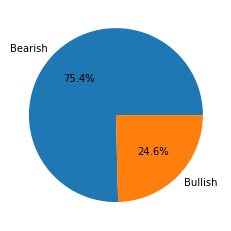

In [6]:
plt.pie(value,autopct='%1.1f%%',labels=['Bearish','Bullish'])
plt.show()

In [7]:
from sklearn.ensemble import RandomForestClassifier

In [8]:
tvec = TfidfVectorizer(stop_words=None, max_features=100000, ngram_range=(1, 3))
# Instantiate model with 100 decision trees
rf = RandomForestClassifier(n_estimators = 100, random_state = 42,criterion ='entropy')

from sklearn.model_selection import StratifiedKFold

def rf_cv(splits, X, Y, pipeline, average_method):
    
    kfold = StratifiedKFold(n_splits=splits, shuffle=True, random_state=777)
    accuracy = []
    precision = []
    recall = []
    f1 = []
    
    correctly_classified = []
    for train, test in kfold.split(X, Y):
        rf_fit = pipeline.fit(X[train], Y[train])
        prediction = rf_fit.predict(X[test])
        scores = rf_fit.score(X[test],Y[test])
        
        conmat = np.array(confusion_matrix(Y[test], prediction))
        correctly_classified.append(conmat[0][0]+conmat[1][1])
        confusion = pd.DataFrame(conmat, index=['Bearish', 'Bullish'],
                         columns=['predicted_Bearish','predicted_Bullish'])
        print(confusion)
        print('\n')
        
        accuracy.append(scores * 100)
        precision.append(precision_score(Y[test], prediction, average=average_method)*100)
        print('              Bearish    Bullish')
        print('precision:',precision_score(Y[test], prediction, average=None))
        recall.append(recall_score(Y[test], prediction, average=average_method)*100)
        print('recall:   ',recall_score(Y[test], prediction, average=None))
        f1.append(f1_score(Y[test], prediction, average=average_method)*100)
        print('f1 score: ',f1_score(Y[test], prediction, average=None))
        
        #print("Classification Report\n")
        #print(classification_report(Y[test], prediction))
        print('-'*50)

    print("accuracy: %.2f%% (+/- %.2f%%)" % (np.mean(accuracy), np.std(accuracy)))
    print("precision: %.2f%% (+/- %.2f%%)" % (np.mean(precision), np.std(precision)))
    print("recall: %.2f%% (+/- %.2f%%)" % (np.mean(recall), np.std(recall)))
    print("f1 score: %.2f%% (+/- %.2f%%)" % (np.mean(f1), np.std(f1)))
    return sum(correctly_classified)

In [10]:
from sklearn.pipeline import Pipeline

original_pipeline = Pipeline([('vectorizer', tvec),('classifier', rf)])
imbalance_correctly_classified = rf_cv(3, df.cleaned_message,df.sentiment, original_pipeline, 'macro')
imbalance_correctly_classified

         predicted_Bearish  predicted_Bullish
Bearish                 56                407
Bullish                 40               1382


              Bearish    Bullish
precision: [0.58333333 0.7724986 ]
recall:    [0.12095032 0.9718706 ]
f1 score:  [0.20035778 0.86079103]
--------------------------------------------------
         predicted_Bearish  predicted_Bullish
Bearish                 78                386
Bullish                 20               1401


              Bearish    Bullish
precision: [0.79591837 0.78399552]
recall:    [0.16810345 0.9859254 ]
f1 score:  [0.27758007 0.8734414 ]
--------------------------------------------------
         predicted_Bearish  predicted_Bullish
Bearish                 52                412
Bullish                 23               1398


              Bearish    Bullish
precision: [0.69333333 0.77237569]
recall:    [0.11206897 0.98381422]
f1 score:  [0.19294991 0.86536676]
--------------------------------------------------
accuracy: 77.

4367

### oversampling

In [11]:
ROS_pipeline = make_pipeline(tvec, RandomOverSampler(random_state=777),rf)

In [13]:
oversampling_correctly_classified = rf_cv(3, df.cleaned_message, df.sentiment, ROS_pipeline, 'macro')
oversampling_correctly_classified

         predicted_Bearish  predicted_Bullish
Bearish                135                328
Bullish                106               1316


              Bearish    Bullish
precision: [0.56016598 0.80048662]
recall:    [0.29157667 0.9254571 ]
f1 score:  [0.38352273 0.85844749]
--------------------------------------------------
         predicted_Bearish  predicted_Bullish
Bearish                148                316
Bullish                 74               1347


              Bearish    Bullish
precision: [0.66666667 0.80998196]
recall:    [0.31896552 0.947924  ]
f1 score:  [0.43148688 0.87354086]
--------------------------------------------------
         predicted_Bearish  predicted_Bullish
Bearish                120                344
Bullish                 71               1350


              Bearish    Bullish
precision: [0.62827225 0.79693034]
recall:    [0.25862069 0.95003519]
f1 score:  [0.36641221 0.86677368]
--------------------------------------------------
accuracy: 78.

4416

## SMOTE - Synthetic Minority Over-Sampling Technique

In [14]:
SMOTE_pipeline = make_pipeline(tvec, SMOTE(random_state=777),rf)

In [16]:
smote_correctly_classified = rf_cv(3, df.cleaned_message, df.sentiment, SMOTE_pipeline, 'macro')
smote_correctly_classified

         predicted_Bearish  predicted_Bullish
Bearish                 72                391
Bullish                 45               1377


              Bearish    Bullish
precision: [0.61538462 0.77884615]
recall:    [0.15550756 0.96835443]
f1 score:  [0.24827586 0.86332288]
--------------------------------------------------
         predicted_Bearish  predicted_Bullish
Bearish                 72                392
Bullish                 24               1397


              Bearish    Bullish
precision: [0.75       0.78088317]
recall:    [0.15517241 0.98311049]
f1 score:  [0.25714286 0.87040498]
--------------------------------------------------
         predicted_Bearish  predicted_Bullish
Bearish                 67                397
Bullish                 32               1389


              Bearish    Bullish
precision: [0.67676768 0.77771557]
recall:    [0.14439655 0.97748065]
f1 score:  [0.23801066 0.86623012]
--------------------------------------------------
accuracy: 77.

4374

### SVM

In [46]:
from sklearn.svm import SVC

In [47]:
tvec = TfidfVectorizer(stop_words=None, max_features=100000, ngram_range=(1, 3))
# Instantiate model with 100 decision trees
sv = SVC(kernel='linear', C = 1.0)

from sklearn.model_selection import StratifiedKFold

def sv_cv(splits, X, Y, pipeline, average_method):
    
    kfold = StratifiedKFold(n_splits=splits, shuffle=True, random_state=777)
    accuracy = []
    precision = []
    recall = []
    f1 = []
    
    correctly_classified = []
    for train, test in kfold.split(X, Y):
        sv_fit = pipeline.fit(X[train], Y[train])
        prediction = sv_fit.predict(X[test])
        scores = sv_fit.score(X[test],Y[test])
        
        conmat = np.array(confusion_matrix(Y[test], prediction))
        correctly_classified.append(conmat[0][0]+conmat[1][1])
        confusion = pd.DataFrame(conmat, index=['Bearish', 'Bullish'],
                         columns=['predicted_Bearish','predicted_Bullish'])
        print(confusion)
        print('\n')
        
        accuracy.append(scores * 100)
        precision.append(precision_score(Y[test], prediction, average=average_method)*100)
        print('              Bearish    Bullish')
        print('precision:',precision_score(Y[test], prediction, average=None))
        recall.append(recall_score(Y[test], prediction, average=average_method)*100)
        print('recall:   ',recall_score(Y[test], prediction, average=None))
        f1.append(f1_score(Y[test], prediction, average=average_method)*100)
        print('f1 score: ',f1_score(Y[test], prediction, average=None))
        
        #print("Classification Report\n")
        #print(classification_report(Y[test], prediction))
        print('-'*50)

    print("accuracy: %.2f%% (+/- %.2f%%)" % (np.mean(accuracy), np.std(accuracy)))
    print("precision: %.2f%% (+/- %.2f%%)" % (np.mean(precision), np.std(precision)))
    print("recall: %.2f%% (+/- %.2f%%)" % (np.mean(recall), np.std(recall)))
    print("f1 score: %.2f%% (+/- %.2f%%)" % (np.mean(f1), np.std(f1)))
    return sum(correctly_classified)

In [48]:
from sklearn.pipeline import Pipeline

original_pipeline = Pipeline([('vectorizer', tvec),('classifier', sv)])
imbalance_correctly_classified = sv_cv(3, df.cleaned_message,df.label, original_pipeline, 'macro')
imbalance_correctly_classified

         predicted_Bearish  predicted_Bullish
Bearish                 49                115
Bullish                 19                479


              Bearish    Bullish
precision: [0.72058824 0.80639731]
recall:    [0.29878049 0.96184739]
f1 score:  [0.42241379 0.87728938]
--------------------------------------------------
         predicted_Bearish  predicted_Bullish
Bearish                 44                119
Bullish                 12                486


              Bearish    Bullish
precision: [0.78571429 0.80330579]
recall:    [0.26993865 0.97590361]
f1 score:  [0.40182648 0.881233  ]
--------------------------------------------------
         predicted_Bearish  predicted_Bullish
Bearish                 43                120
Bullish                 18                480


              Bearish    Bullish
precision: [0.70491803 0.8       ]
recall:    [0.26380368 0.96385542]
f1 score:  [0.38392857 0.87431694]
--------------------------------------------------
accuracy: 79.

1581

### oversampling

In [49]:
ROS_pipeline = make_pipeline(tvec, RandomOverSampler(random_state=777),sv)

oversampling_correctly_classified = sv_cv(3, df.cleaned_message, df.label, ROS_pipeline, 'macro')
oversampling_correctly_classified

         predicted_Bearish  predicted_Bullish
Bearish                 78                 86
Bullish                 56                442


              Bearish    Bullish
precision: [0.58208955 0.83712121]
recall:    [0.47560976 0.8875502 ]
f1 score:  [0.52348993 0.86159844]
--------------------------------------------------
         predicted_Bearish  predicted_Bullish
Bearish                 74                 89
Bullish                 34                464


              Bearish    Bullish
precision: [0.68518519 0.83905967]
recall:    [0.45398773 0.93172691]
f1 score:  [0.54612546 0.8829686 ]
--------------------------------------------------
         predicted_Bearish  predicted_Bullish
Bearish                 77                 86
Bullish                 44                454


              Bearish    Bullish
precision: [0.63636364 0.84074074]
recall:    [0.47239264 0.91164659]
f1 score:  [0.54225352 0.87475915]
--------------------------------------------------
accuracy: 80.

1589

###  SMOTE - Synthetic Minority Over-Sampling Technique

In [51]:
SMOTE_pipeline = make_pipeline(tvec, SMOTE(random_state=777),sv)

smote_correctly_classified = sv_cv(3, df.cleaned_message, df.label, SMOTE_pipeline, 'macro')
smote_correctly_classified

         predicted_Bearish  predicted_Bullish
Bearish                 82                 82
Bullish                 61                437


              Bearish    Bullish
precision: [0.57342657 0.84200385]
recall:    [0.5        0.87751004]
f1 score:  [0.53420195 0.85939036]
--------------------------------------------------
         predicted_Bearish  predicted_Bullish
Bearish                 75                 88
Bullish                 45                453


              Bearish    Bullish
precision: [0.625      0.83733826]
recall:    [0.4601227  0.90963855]
f1 score:  [0.53003534 0.8719923 ]
--------------------------------------------------
         predicted_Bearish  predicted_Bullish
Bearish                 76                 87
Bullish                 48                450


              Bearish    Bullish
precision: [0.61290323 0.83798883]
recall:    [0.46625767 0.90361446]
f1 score:  [0.52961672 0.86956522]
--------------------------------------------------
accuracy: 79.

1573